# SPASE Record Analysis - How to Use 
Author: Zach Boquet

## Introduction 
For documentation on how to add to this project, view the related notebook named "HowToAdd.ipynb" <br>
<br>
This project provides a method to analyze FAIR for the SPASE records in the NumericalData and DisplayData categories.<br>

This notebook shows you how to convert desired SPASE record fields into a SQLite database. The desired fields correspond to metadata extracted from XML files using ElementTree. Also shown is how to query data from that database. <br> 
- The tutorial I used to implement ElementTree is <a href="https://realpython.com/python-xml-parser/" target="_blank">https://realpython.com/python-xml-parser/</a>. 
- If more context is needed for the SQLite code than is provided by the comments, I recommend visiting <a href="https://www.sqlitetutorial.net/" target="_blank">https://www.sqlitetutorial.net/</a>.<br>

*Note that this code was extensively tested on the NASA SPASE Github repo. However, results are not guaranteed when running on other SPASE Github repos. This code was tested in Summer 2024 on SPASE version 2.6.1*

This program takes ~3.88 minutes (233 seconds) to fully run from scratch on over 3000 records.

You can also run the program using older database files found in the repo history. Simply change the name of the parameter to the create_sqlite_database function in the first cell to the name of the .db file you wish to use.

## Installation
First, make sure these scripts are installed. Please see the readme file for instructions. Then, clone the NASA SPASE Github Repository <a href="https://github.com/hpde/NASA/tree/master" target="_blank">https://github.com/hpde/NASA/tree/master</a> by executing the following code. Lastly, make sure you have the necessary packages and Python scripts imported below, which can be found in the same repo you found this notebook, linked again here: <a href="https://github.com/Kurokio/HDRL-Internship-2024" target="_blank">https://github.com/Kurokio/HDRL-Internship-2024</a>.

In [ ]:
# clone NASA SPASE Github Repo into the directory above this tutorial.
! git clone -b master --single-branch --depth=1 https://github.com/hpde/NASA ../../NASA

In [ ]:
# show your current directory
! pwd

## Scraping the SPASE records and populating our tables

This code block performs the following: <br>

- takes the absolute path of a SPASE directory they wish to be scraped as an argument<br>
- finds all desired metadata <br>
- creates all needed tables <br>
- adds an entry for each record found into the MetadataEntries table. <br>
- stores the locations of where each metadata field is found in the MetadataSources table <br>
- adds entries into the Records table with general info and info needed for database maintenance.<br>
- populate the TestResults table with default values. <br>
- update the columns associated with a given analysis test (i.e records that have authors -> has_author column) to have a 'True' value of 1.<br>
<br>

If you want a full printout of everything being done, pass True as the printFlag argument to Create.<br>

Examples are also found as comments at the bottom of the code block to test smaller, yet complex directories.<br>
Note: This code was designed to work for the NumericalData and DisplayData directories, so inputting directories besides those two may cause logical errors and produce unintended results.

### Starting from an Existing Database
A pre-built database is included in this repository. You can use this database as a starting point.

In [2]:
from Scripts import create_sqlite_database

help(create_sqlite_database)

Help on function create_sqlite_database in module Scripts.SQLiteFun:

create_sqlite_database(filename)
    Creates a database connection to a new or existing SQLite database with
    the name provided. If the database already exists, it returns
    a connection object. This also tells you any errors that may occur.
    
    :param filename: String that contains the desired name of the database
    :type filename: String
    :return: Connection object



In [3]:
# input abs path of database file you wish to load from, located one directory above this notebook
conn = create_sqlite_database("../SPASE_Data_20240716.db")

### Creating or Updating a Database
Use the next two blocks if you wish to update the database using the current version of the chosen SPASE repository. Otherwise, skip to the next section.

#### Example directories
 
Overall paths (>3000 records): "../../NASA/NumericalData" and "../../NASA/DisplayData"  
Smaller subdirectory = "../../NASA/NumericalData/DE2"   
Bigger subdirectory = "../../NASA/NumericalData/ACE"  
Complex author examples: "../../NASA/NumericalData/Cassini/MAG/PT60S.xml" and "../../NASA/NumericalData/ACE/Attitude/Definitive/PT1H.xml"  
Complex URL example: "../../NASA/NumericalData/ACE/CRIS/L2/P1D.xml"  
#### Code

In [1]:
# import main Python function
from Scripts import Create
from Scripts import create_sqlite_database

# connect to the desired database file
conn = create_sqlite_database("../SPASE_Data_new.db")
help(Create)

Help on function Create in module Scripts.main:

Create(folder, conn, printFlag=False)
    Scrapes all records that are found in the directory given
    for the desired metadata. Creates the MetadataEntries,
    MetadataSources, Records, and TestResults tables and populates
    them using the data scraped for each record. Populates the
    TestResult table with default values to be overwritten by
    the call to the FAIRScorer function in the notebook.
    
    :param folder: The absolute file path of the SPASE record/directory
                        containing the record(s) the user wants scraped.
    :type folder: String
    :param conn: A connection to the desired database
    :type conn: Connection object
    :param printFlag: A boolean determining if the user wants to print
                        more details of what the function is doing.
    :type printFlag: Boolean
    :return: None



In [4]:
# This block updates current records from the indicated directories in the MetadataEntries table
# This step can take a while if you start with a new database file.
# Starting with an existing database file significantly speeds this up.
Create('../../NASA/NumericalData/ACE', conn)

You entered ../../NASA/NumericalData/ACE
Discovering SPASE records....
The number of records is 163
Metadata extraction complete.                        
TestResult entries completed
Metadata successfully stored in the SQL tables.


These few lines simply connect to a new database file and update the database using the SPASE records in the desired directory.

### Understanding the Database Structure
The graphic below shows the contents of the four tables created by this program. The main topic of the tables are in orange, the column contents are in yellow, and notes are in blue. The exact names are shown in the code blocks below.


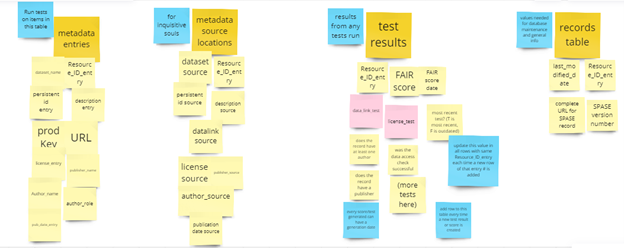

This code block shows you all the table names and their column names in the database that was used.

In [15]:
from Scripts import databaseInfo

help(databaseInfo)

Help on function databaseInfo in module Scripts.SQLiteFun:

databaseInfo(conn, print_flag=True)
    Prints all table names and all the names of their associated columns
    
    :param conn: A connection to the desired database
    :type conn: Connection object
    :return: dictionary with table names as keys and column names as values



In [16]:
name_dict = databaseInfo(conn)

The table MetadataEntries has columns:
['rowNum', 'SPASE_id', 'author', 'authorRole', 'publisher', 'publicationYr', 'datasetName', 'license', 'URL', 'prodKey', 'description', 'PID']

The table MetadataSources has columns:
['rowNum', 'SPASE_id', 'author_source', 'publisher_source', 'publication_yr_source', 'datasetName_source', 'license_source', 'datalink_source', 'description_source', 'PID_source']

The table TestResults has columns:
['rowNum', 'SPASE_id', 'FAIR_Score', 'FAIR_ScoreDate', 'MostRecent', 'has_author', 'has_pub', 'has_pubYr', 'has_datasetName', 'has_license', 'has_url', 'has_NASAurl', 'has_PID', 'has_desc', 'has_citation', 'has_compliance', 'Errors']

The table Records has columns:
['rowNum', 'SPASE_id', 'SPASE_Version', 'LastModified', 'SPASE_URL']



## Executing Analysis Tests and Viewing the Results 
In this code block, we perform calls to the QueryPrinter script to get the Counts and/or ID's of the SPASE records that pass each analysis test. 
These analysis tests include links that have: <br> 

- authors <br>
- publishers <br>
- publication years <br>
- dataset names <br>
- licenses <br>
- URLs <br>
- NASA URLs <br>
- persistent identifiers <br>
- descriptions <br>
- citation info <br>
- DCAT-3 compliance info.<br>
### Executing the Analysis Tests

In [13]:
# this function returns all records that pass associated tests 
# and prints the counts of those that pass the test specified in the argument
from Scripts import View

help(View)

Help on function View in module Scripts.main:

View(conn, All=True, desired=['all', 'Author', 'Publisher', 'Publication Year', 'Dataset Name', 'CC0 License', 'URL', 'NASA URL', 'Persistent Identifier', 'Description', 'Citation', 'DCAT3-US Compliance'], print_flag=True)
    Prints the number of records that meet each test criteria
    provided as well as return those SPASE_id's to the caller
    in the form of a dictionary. The keys are the Strings passed
    as parameters and the values are the list of SPASE_id's
    that fulfill that test.
    
    :param conn: A connection to the desired database
    :type conn: Connection object
    :param All: A boolean determining if the records returned will be from
                the set containing all records present in the database or
                only those with NASA URLs.
    :type All: Boolean
    :param desired: A list of Strings which determine the kind of records
                    whose counts are printed and whose SPASE_id's are
 

In [ ]:
# example that returns values for one test
records = View(conn, desired = ['Citation'])

In [ ]:
# example that returns values for 4 tests, one of which doesn't match
records = View(conn, desired = ['Author', 'Publisher', 'NASA URL', 'Compliance'])

In [14]:
# example that returns values for all tests
records = View(conn)

There are 3034 records total.
There are 2907 records with an author.
There are 3034 records with a publisher.
There are 1884 records with a publication year.
There are 3034 records with a dataset.
There are 0 records with a CC0 license.
There are 3034 records with a URL.
There are 2254 records with a NASA URL.
There are 1863 records with a persistent identifier.
There are 3034 records with a description.
There are 1884 records with citation info.
There are 1863 records that meet DCAT3-US compliance.


In [17]:
# understanding the structure of the records dictionary returned
# The name of the metadata and the number of records with that field are shown below.
print("Metadata Name, Number of records, Example record name")
print("-----------------------------------------------------")
for key in records.keys():
    if len(records[key]) > 0:
        print(key, ',', len(records[key]), ',', records[key][0])
    else:
        print(key, ',', len(records[key]), ', N/A')

Metadata Name, Number of records, Example record name
-----------------------------------------------------
all , 3034 , spase://NASA/DisplayData/ACE/MAG/27-Day
Author , 2907 , spase://NASA/DisplayData/ACE/MAG/27-Day
Publisher , 3034 , spase://NASA/DisplayData/ACE/MAG/27-Day
Publication Year , 1884 , spase://NASA/DisplayData/POLAR/VIS/PT300S
Dataset Name , 3034 , spase://NASA/DisplayData/ACE/MAG/27-Day
CC0 License , 0 , N/A
URL , 3034 , spase://NASA/DisplayData/ACE/MAG/27-Day
NASA URL , 2254 , spase://NASA/DisplayData/ACE/MAG/27-Day
Persistent Identifier , 1863 , spase://NASA/DisplayData/POLAR/VIS/PT300S
Description , 3034 , spase://NASA/DisplayData/ACE/MAG/27-Day
Citation , 1884 , spase://NASA/DisplayData/POLAR/VIS/PT300S
DCAT3-US Compliance , 1863 , spase://NASA/DisplayData/POLAR/VIS/PT300S


### Plotting the Analysis Results

In [ ]:
# This function creates a bar chart for the metadata fields checked.
from Scripts import MetadataBarChart

help(MetadataBarChart)

In [ ]:
# Plotting the bar chart for all records 
fig = MetadataBarChart(conn)

In [ ]:
# Plotting the percent version of the same bar chart
fig = MetadataBarChart(conn, percent = True)

In [ ]:
# Plotting the bar chart for only records with a NASA URL
fig = MetadataBarChart(conn, All = False)

In [ ]:
# Plotting the percent version of the same bar chart
fig = MetadataBarChart(conn, percent = True, All = False)

## Calculating and plotting the FAIR Score Distributions
This code overwrites the default values placed in the TestResults table to have the actual FAIR Scores that are calculated according to the following algorithm:<br>

- +1 for author
- +1 for dataset name
- +1 for publication year
- +1 for publisher
- +1 for all citation info
- +1 for description
- +1 for PID
- +1 for DCAT3-US compliance
- +1 for license
- +1 for NASA URL <br>
======================= <br>
- Total Possible Points of 10

*Note that this alogrithm is expected to change*

If interested in viewing the FAIR Score for a particular record, refer to the column-specific queries section further below.  

### Calculating the FAIR Scores
These two code blocks only need to be run if the database has been updated.

In [8]:
from Scripts import FAIRScorer

help(FAIRScorer)

Help on function FAIRScorer in module Scripts.SQLiteFun:

FAIRScorer(conn)
    Iterates through the has_x column names of the TestResults table
    to calculate the FAIR Score of all the records in the parameter.
    FAIR Score is calculated according to the algorithm described in
    the notebook. Once the FAIR score is calculated, the FAIR_Score,
    MostRecent, and FAIR_ScoreDate columns are updated for that record.
    
    :param conn: A connection to the desired database
    :type conn: Connection object
    :return: None



In [9]:
# calculate FAIR scores for all records
FAIRScorer(conn)

Analyzing 3034 records found
FAIR scores calculated. Use the View function to see the results.


### Plotting the FAIR Score Distributions

In [10]:
from Scripts import FAIR_Chart

help(FAIR_Chart)

Help on function FAIR_Chart in module Scripts.PlotScripts:

FAIR_Chart(conn, All=True)
    Executes a SQLite SELECT statement to collect all FAIR Scores
    and displays a bar chart showing the number of records for each
    FAIR Score. This does so by using NumPy arrays within a MatPlotLib
    function. The default value for All is True, which uses data from
    all the records in the database. Passing False to the All parameter
    performs the same, but only for the records with NASA URLs.
    
    :param conn: A connection to the desired database
    :type conn: Connection object
    :param All: A boolean determining whether or not to use all records
                    in the database or only those with NASA URLs.
    :type All: Boolean
    :return: the figure



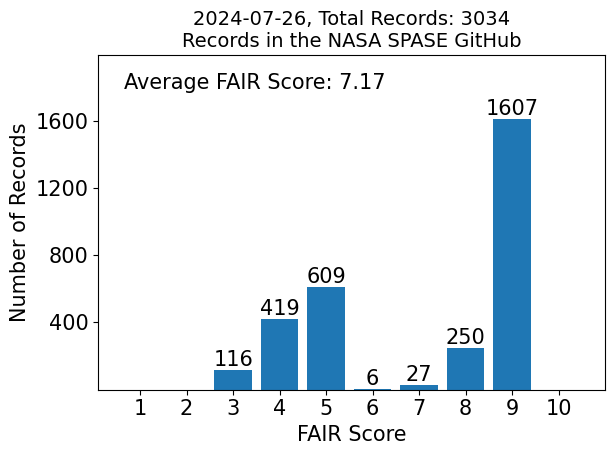

In [11]:
# for all records
fig = FAIR_Chart(conn)

In [ ]:
# only for records with NASA URLs
fig = FAIR_Chart(conn, All = False)

## How to do your own queries 
This section gives examples of how to query the database for row specific and column specific queries. Also provided are brief explanations of some of the SQLite syntax and also an example of a complex query for both categories. <br>

If more context is needed for the SQLite code than is provided by the comments, I recommend visiting <a href="https://www.sqlitetutorial.net/" target="_blank">https://www.sqlitetutorial.net/</a>.<br>

*Disclaimer: Not all authors are provided, as checks were only done to find if an allowed author exists.* 
<br>
**Also note that when a SPASE record has multiple product keys for one URL or multiple URLs in general, each URL/product key gets their own entry into the table. This is why there may be 'duplicate entries' in the database.**

### Record Specific Queries

This section describes how to get data with queries based on records/rows.

In [ ]:
from Scripts import execution

help(execution)

> Ex: How to get a ResourceID

> - Use """SELECT columnName FROM TableName WHERE columnName = x""" where x is of proper data type.

In [ ]:
# Gets the SPASE ID from the 10th row
stmt = """ SELECT SPASE_id FROM MetadataEntries WHERE rowNum = 10 """
items = execution(stmt, conn)
items

> Ex: Get ResourceID by specifying the xml file name

> - Use "LIKE '%text%'" instead of '= x' for when you need to query on partial info.

> - SQLite uses the '%' as the multi-character wildcard and '_' as the single character wildcard.

> - Use DISTINCT to prevent duplicate rows.

In [ ]:
# Gets a list of SPASE IDs that have the given string in the ID
# This example gets all 100 of the SPASE IDs from MMS with Burst in the ID.
stmt = """ SELECT DISTINCT(SPASE_id) FROM MetadataEntries WHERE SPASE_id LIKE '%/MMS/%/Burst/%' """
items = execution(stmt, conn)
print(len(items))

> Ex: Searching table for ResourceID using a specific value of a column

In [ ]:
# This example looks for the SPASE ID that has the given text in the dataset name.
ds = "Interball Aurora MAG 2-min Key Parameters"
stmt = f""" SELECT DISTINCT(SPASE_id) FROM MetadataEntries WHERE datasetName = '{ds}' """
items = execution(stmt, conn)
items

> Ex: How to get all data for a SPASE record using the ResourceID
> - Put 'multiple' as the second optional arg for execution when selecting more than 1 item.

>> This example prints out the following data in a list of tuples, where each tuple is a distinct row in the table. The tuples follow the following printout format:
>> - rowNum
>> - SPASE_id
>> - author
>> - authorRole (if relevant)
>> - publisher
>> - publication year
>> - datasetName
>> - license
>> - url (if NASA URL)
>> - prodKey
>> - description
>> - PID

In [ ]:
# Confirm that the dataset name for the SPASE ID matches.
# This SPASE ID has information on four rows, so the dataset name for all four rows is printed.
ID = "spase://NASA/NumericalData/Interball-2/IMAP3/PT120S"
stmt = f""" SELECT datasetName FROM MetadataEntries WHERE SPASE_id = '{ID}' """
rows = execution(stmt, conn)
rows

In [ ]:
# Now that you have a SPASE_ID, this example gets all the metadata for that record
ID = "spase://NASA/NumericalData/Interball-2/IMAP3/PT120S"
stmt = f""" SELECT * FROM MetadataEntries WHERE SPASE_id = '{ID}' """
rows = execution(stmt, conn, "multiple")

In [ ]:
# Retrieving the database sturcture to understand the types of items printed
from Scripts import databaseInfo

name_dict = databaseInfo(conn, print_flag=False)
for row in rows:
    for name, item in zip(name_dict['MetadataEntries'], row):
        print(name, ':', item)
    print()

> To get the actual description, use the SPASE_DataPrinter function

In [ ]:
from Scripts import MetadataPrinter

help(MetadataPrinter)

In [ ]:
MetadataPrinter(ID, fields = ["description"])

> Ex: How to get the Fair Score for a record

In [ ]:
ID = "spase://NASA/NumericalData/Interball-2/IMAP3/PT120S"
stmt = f""" SELECT DISTINCT(FAIR_Score) FROM TestResults WHERE SPASE_id = '{ID}' """
item = execution(stmt, conn)
item

In [ ]:
# get all the test result fields for a record (used to calculate the FAIR score)
ID = "spase://NASA/NumericalData/Interball-2/IMAP3/PT120S"
stmt = f""" SELECT * FROM TestResults WHERE SPASE_id = '{ID}' """
items = execution(stmt, conn, "multiple")

In [ ]:
# Retrieving the database structure to understand the types of items printed
from Scripts import databaseInfo

name_dict = databaseInfo(conn, print_flag=False)
for row in items:
    for name, item in zip(name_dict['TestResults'], row):
        print(name, ':', item)

> Complex example: Selecting multiple items from multiple tables by using the ResourceID

> - Notice we use commas for multiple items and INNER JOINS when it is over multiple tables.

In [ ]:
ID = "spase://NASA/NumericalData/Interball-2/IMAP3/PT120S"
rows = execution(f""" SELECT author, MetadataSources.author_source, Records.SPASE_URL 
            FROM MetadataEntries
                INNER JOIN MetadataSources USING (SPASE_id)
                INNER JOIN Records USING (SPASE_id)
            WHERE SPASE_id = '{ID}';""", conn)
rows

### Column Specific Queries
This section describes how to get data with queries based on the column values.

> Ex: How many records do not have a NASA URL?

In [ ]:
stmt = """SELECT COUNT(DISTINCT(SPASE_id)) FROM TestResults WHERE has_NASAurl = 0"""
items = execution(stmt, conn)
items

> Ex: What are some examples of SPASE_id's of the records that do not have a NASA URL?
> - Use optional LIMIT x at end to limit how many items are selected.

In [ ]:
stmt = """SELECT DISTINCT(SPASE_id) FROM TestResults WHERE has_NASAurl = 0 LIMIT 10"""
items = execution(stmt, conn)
items

> Ex: How many records have 3 out of 4 fields needed for citation?
> - Use AND and OR operators just like in programming languages.

In [ ]:
stmt = """SELECT COUNT(DISTINCT SPASE_id) FROM TestResults 
                WHERE (has_author = 1 
                AND has_datasetName = 1
                AND has_pubYr = 1)
                OR (has_author = 1 
                AND has_datasetName = 1
                AND has_pub = 1)
                OR (has_author = 1 
                AND has_pub = 1
                AND has_pubYr = 1)
                OR (has_datasetName = 1 
                AND has_pub = 1
                AND has_pubYr = 1)"""
items = execution(stmt, conn)
items

> Ex: How many records have SDAC or SPDF as a publisher?

In [ ]:
stmt = """SELECT COUNT(DISTINCT SPASE_id) FROM MetadataEntries 
                        WHERE (publisher LIKE "%SDAC" OR publisher LIKE 
                               "%Solar Data Analysis Center" 
                               OR publisher LIKE "%SPDF" OR publisher LIKE 
                               "%Space Physics Data Facility")"""
items = execution(stmt, conn)
items

> Ex: How did records in a certain directory do in terms of FAIR scores?
> - Notice that since we are only interested in the most up-to-date FAIR scores, we add the "MostRecent = 'T'" condition.

In [ ]:
stmt = """SELECT DISTINCT(SPASE_id), FAIR_Score FROM TestResults 
                WHERE SPASE_id LIKE '%/ACE/%' AND MostRecent = 'T' LIMIT 10"""
print("Format is as follows: (SPASE_id, FAIR_Score)")
items = execution(stmt, conn)
items

> Ex: How many records have a FAIR Score of x?

In [ ]:
stmt = """SELECT COUNT(DISTINCT SPASE_id) FROM TestResults WHERE FAIR_Score = 9 """
items = execution(stmt, conn)
items

> Complex Ex: What records have at least 2 of the desired fields?
> - Notice we use f-strings to concatenate strings instead of retyping text.

In [ ]:
has_citation = """author NOT LIKE ""
                    AND datasetName NOT LIKE ""
                    AND publicationYr NOT LIKE ""
                    AND publisher NOT LIKE "" """
citationStmt = f"""SELECT DISTINCT SPASE_id FROM MetadataEntries 
                WHERE {has_citation};"""
has_compliance = """ description NOT LIKE ""
                AND datasetName NOT LIKE ""
                AND PID NOT LIKE "" """
complianceStmt = f"""SELECT DISTINCT SPASE_id FROM MetadataEntries 
                WHERE {has_compliance};"""

# at least 2 fields
AL2Stmt = f"""SELECT DISTINCT SPASE_id FROM MetadataEntries 
                WHERE ({has_citation}
                AND
                    {has_compliance}) 
                OR
                    ({has_citation}
                AND
                    PID NOT LIKE "")
                OR
                    ({has_citation}
                AND
                    license LIKE "%cc0%" OR license LIKE "%Creative Commons Zero v1.0 Universal%")
                OR
                    ({has_compliance}
                AND
                    license LIKE "%cc0%" OR license LIKE "%Creative Commons Zero v1.0 Universal%")
                OR
                    ({has_compliance}
                AND 
                    PID NOT LIKE "")
                OR  
                    (PID NOT LIKE ""
                AND
                    license LIKE "%cc0%" OR license LIKE "%Creative Commons Zero v1.0 Universal%") LIMIT 10;"""

items = execution(AL2Stmt, conn)
items

## How to Backup Database
This code generates a backup copy of the live database into a file specified by the filename variable.

*Note that this cannot be run if there is a pending SQL statement or open transaction running.*

In [3]:
from Scripts import executionALL

help(executionALL)

Help on function executionALL in module Scripts.SQLiteFun:

executionALL(stmt, conn)
    Connects to the given SQLite database, creates a cursor object,
    and calls the execute method with the stmt argument. This also
    displays error messages if any arise.
    
    :param stmt: A string of the SQLite statement to be executed.
    :type stmt: String
    :param conn: A connection to the desired database
    :type conn: Connection object
    :return: None



In [12]:
filename = "../SPASE_Data_new_backup.db"
stmt = f"VACUUM main INTO '{filename}'"
items = executionALL(stmt, conn)
items